# Scheduling benchmarks analysis

## Library

In [3]:
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Dict
import pandas as pd
import os
import re
import json
import subprocess
import numpy as np
from scipy import stats
from collections import defaultdict
from sklearn.cluster import DBSCAN

#### Global variables

In [4]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"
ABSOLUTE_RESULTS_DIR_PATH = "/home/cgachod/analysis/results"

def get_result_dir_path(result_dir_name):
    return os.path.join(RESULTS_DIR_PATH, result_dir_name)

def get_absolute_result_dir_path(result_dir_name) :
    return os.path.join(ABSOLUTE_RESULTS_DIR_PATH, result_dir_name)

#### Visualization params

In [5]:
nb_enabled_color = "tab:orange"
nb_disabled_color = "tab:blue"

figure_height = 10 # 10
min_figure_width = 40
figure_width_coeff = 0.3

line_width = 1.0

# Memory Accesses

Filtering functions

In [41]:
def extract_memory_accesses_data(file_path: str) -> dict :
    temp_results_filename = ".results.json"
    result = subprocess.run(
        ["../cpp_parser/build/memory_accesses", file_path, temp_results_filename],
        stdout = subprocess.PIPE,
        universal_newlines = True
    )
    with open(temp_results_filename) as f:
        data = json.load(f)
    return data

def filter_raw_data(data: dict, min_t: float = None, max_t: float = None, min_virt_addr: int = None, max_virt_addr: int = None) -> List[pd.DataFrame] :
    dfs = []
    for cpu_data in data :
        cpu_df = pd.DataFrame({col: cpu_data[col] for col in cpu_data if col != "cpuid"})
        mask = np.array([True for _ in range(len(cpu_df))])
        if min_t :
            mask &= (cpu_df["timestamps"] >= min_t)
        if max_t is not None :
            mask &= (cpu_df["timestamps"] < max_t)
        if min_virt_addr is not None :
            mask &= (cpu_df["virtual_addrs"] >= min_virt_addr)
        if max_virt_addr is not None :
            mask &= (cpu_df["virtual_addrs"] < max_virt_addr)
        cpu_df = cpu_df[mask]
        
        dfs.append(cpu_df)
    return dfs


def plot_filtered_data(dataframes: List[pd.DataFrame], column = "virtual_addrs", plot_type = "plot", title: str = None, width = None, height = None, x_min = None, x_max = None) :
    for cpu_df in dataframes :
        if plot_type == "scatter" :
            plt.scatter(cpu_df["timestamps"], cpu_df[column], s=6, alpha=0.5)
        elif plot_type == "plot" :
            plt.plot(cpu_df["timestamps"], cpu_df[column], marker='o', linestyle='--')
    fig = plt.gcf()
    if width is None :
        width = 28
    if height is None :
        height = 12
    fig.set_size_inches(width, height)
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    
    if title is not None :
        plt.title(title)
    
    plt.xlabel("Time (seconds)")
    plt.ylabel("Virtual address")
    if x_min is not None and x_max is not None :
        plt.xlim(x_min, x_max)
    plt.show()
    

colors = ["blue", "yellow"]

def plot_memory_access_nodes(dataframes: List[pd.DataFrame], column = "virtual_addrs", plot_type = "scatter", title: str = None, width = None, height = None, x_min = None, x_max = None) :
    for cpu_df in dataframes :
        nodes = cpu_df["physical_nodes"].unique()
        for n in nodes :
            node_df = cpu_df[cpu_df["physical_nodes"] == n]
            plt.scatter(node_df["timestamps"], node_df["physical_addrs"], s=6, alpha=0.5, c=colors[n])
    fig = plt.gcf()
    if width is None :
        width = 28
    if height is None :
        height = 12
    fig.set_size_inches(width, height)
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    
    if title is not None :
        plt.title(title)
    
    plt.xlabel("Time (seconds)")
    plt.ylabel("Virtual address")
    if x_min is not None and x_max is not None :
        plt.xlim(x_min, x_max)
    plt.show()


In [56]:
data = extract_memory_accesses_data(get_result_dir_path("_memory/cg.C.x__dahu-32__v6.8.0-rc6+__performance__2024-04-03/nb-enabled-test/cg.C.x__dahu-32__v6.8.0-rc6+__performance__2024-04-03__nb-enabled-test__4.log"))
combined_df = pd.concat(filter_raw_data(data), ignore_index=True)


node_0_phys_addrs = combined_df[combined_df["physical_nodes"] == 0]["physical_addrs"]
node_1_phys_addrs = combined_df[combined_df["physical_nodes"] == 1]["physical_addrs"]

limits = [node_0_phys_addrs.min(), node_0_phys_addrs.max(), node_1_phys_addrs.min(), node_1_phys_addrs.max()]
for l in limits :
    print(hex(l).rjust(12))
    
def is_node_1(addr) :
    return addr >= node_1_phys_addrs.min()

 0x114048000
0x183ff8b000
0x184d0eb000
0x303fe3f000


In [2]:
hex(25427968) # cf /proc/zoneinfo

'0x1840000'

In [7]:
hex(1789999)

'0x1b502f'

Clustering functions

In [8]:
def get_clusters_1D(values: np.array, eps: int, min_size: int) -> Tuple[list, list] :
    sorted_values = np.sort(values)
    prev_val = np.concatenate(([sorted_values[0]],sorted_values[:-1])) # n - 1
    virtual_addresses_minus_diff = np.absolute(sorted_values - prev_val) # addr[i] - addr[i - 1]
    
    indices = np.where(virtual_addresses_minus_diff > eps)[0]
    
    clusters_bounds = [] # (min, max excluded)
    clusters_lengths = []
    if indices[0] >= min_size :
        clusters_bounds.append( (0, sorted_values[indices[0]]) )
        clusters_lengths.append(indices[0])
    for i in range(len(indices) - 1) :
        cluster_len = indices[i + 1] - indices[i]
        if cluster_len < min_size :
            continue
        clusters_bounds.append(( sorted_values[indices[i]], sorted_values[indices[i + 1]] ))
        clusters_lengths.append(cluster_len)
    
    return clusters_bounds, clusters_lengths


def get_virtual_addrs_clusters(data: dict) -> Tuple[list, list] :
    return get_clusters_1D(np.concatenate([np.array(cpu['virtual_addrs']) for cpu in data]), 1e7, 10)



Plotting

In [32]:
data = extract_memory_accesses_data(get_result_dir_path("_memory/cg.C.x__dahu-32__v6.8.0-rc6+__performance__2024-04-03/nb-enabled-test/cg.C.x__dahu-32__v6.8.0-rc6+__performance__2024-04-03__nb-enabled-test__4.log"))

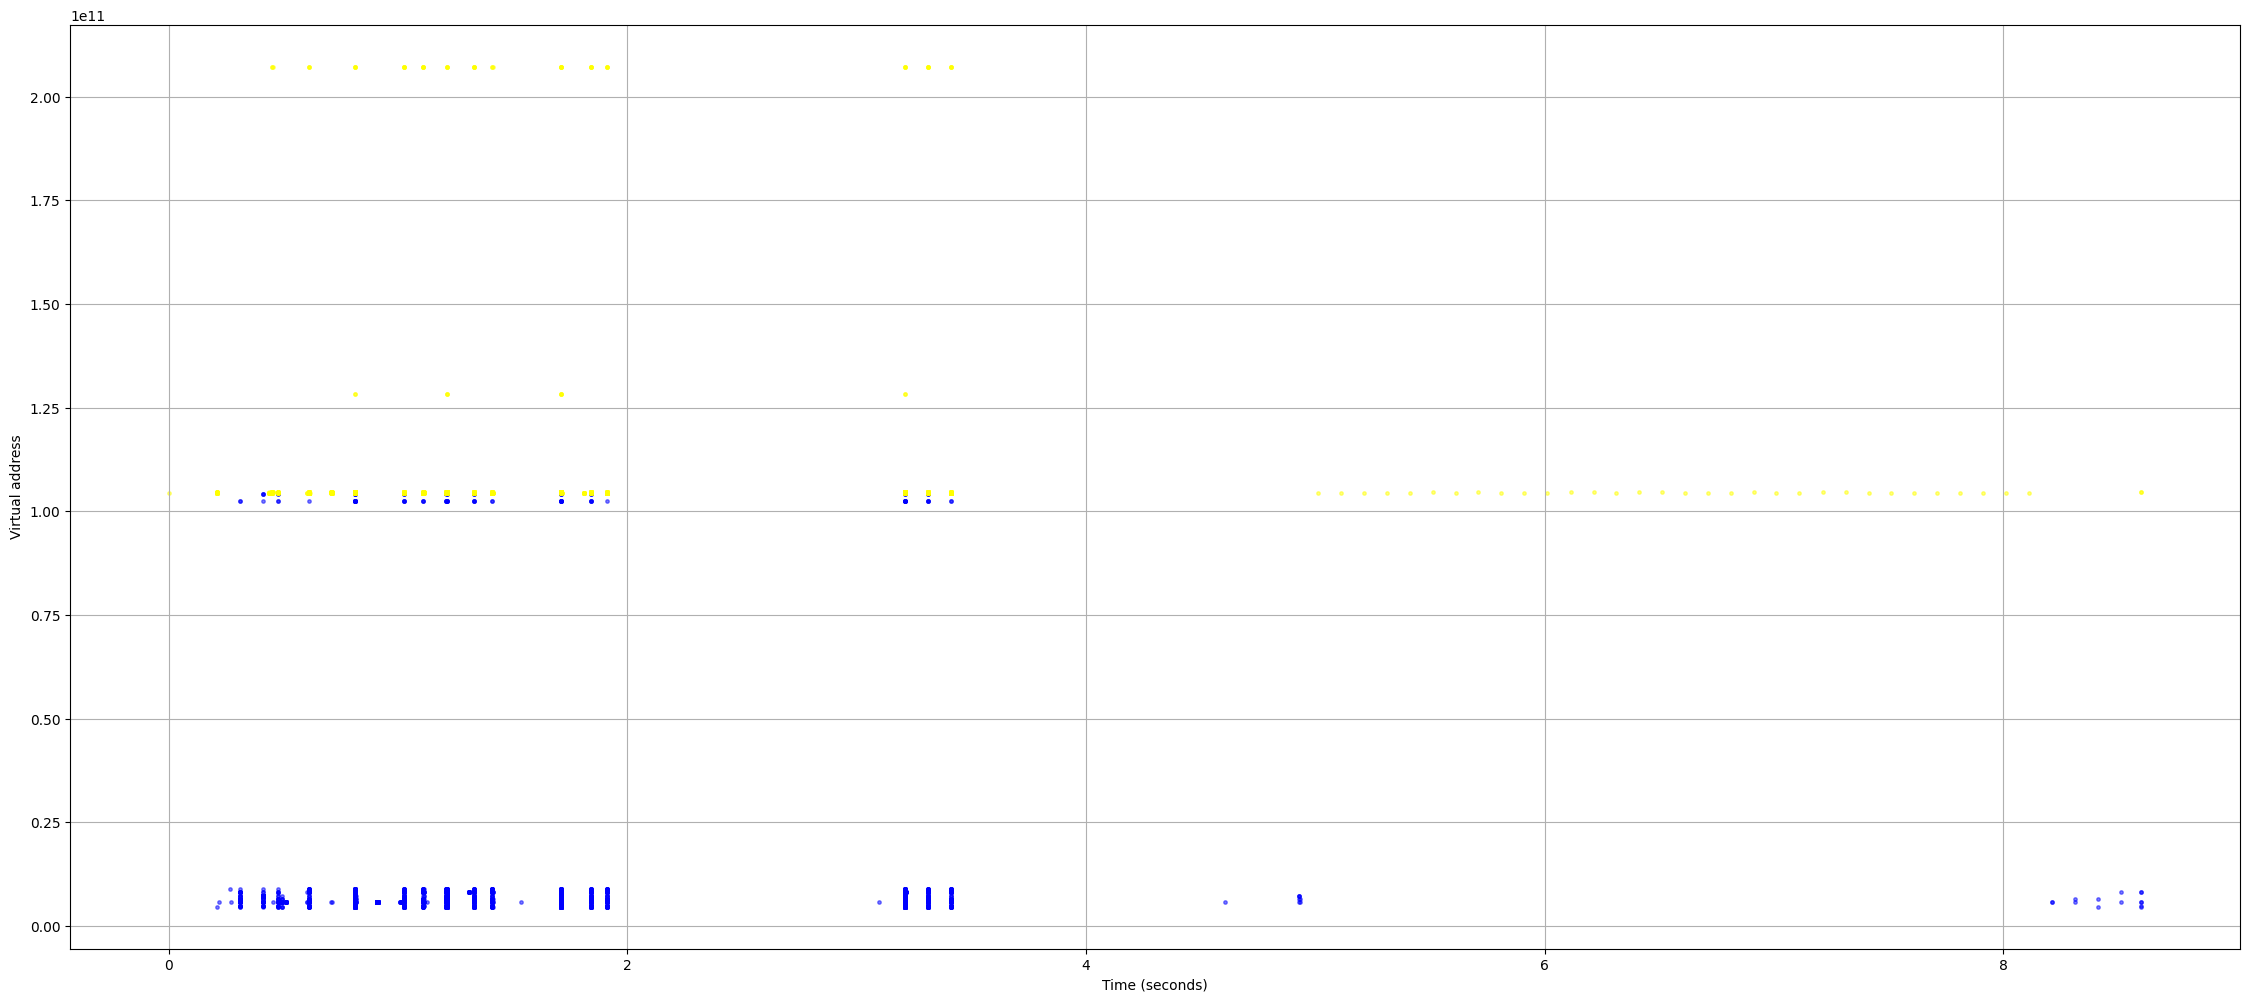

In [42]:
plot_memory_access_nodes(filter_raw_data(data))

[(0, 237), (1, 124), (2, 3136), (3, 1295), (4, 998), (5, 18)]


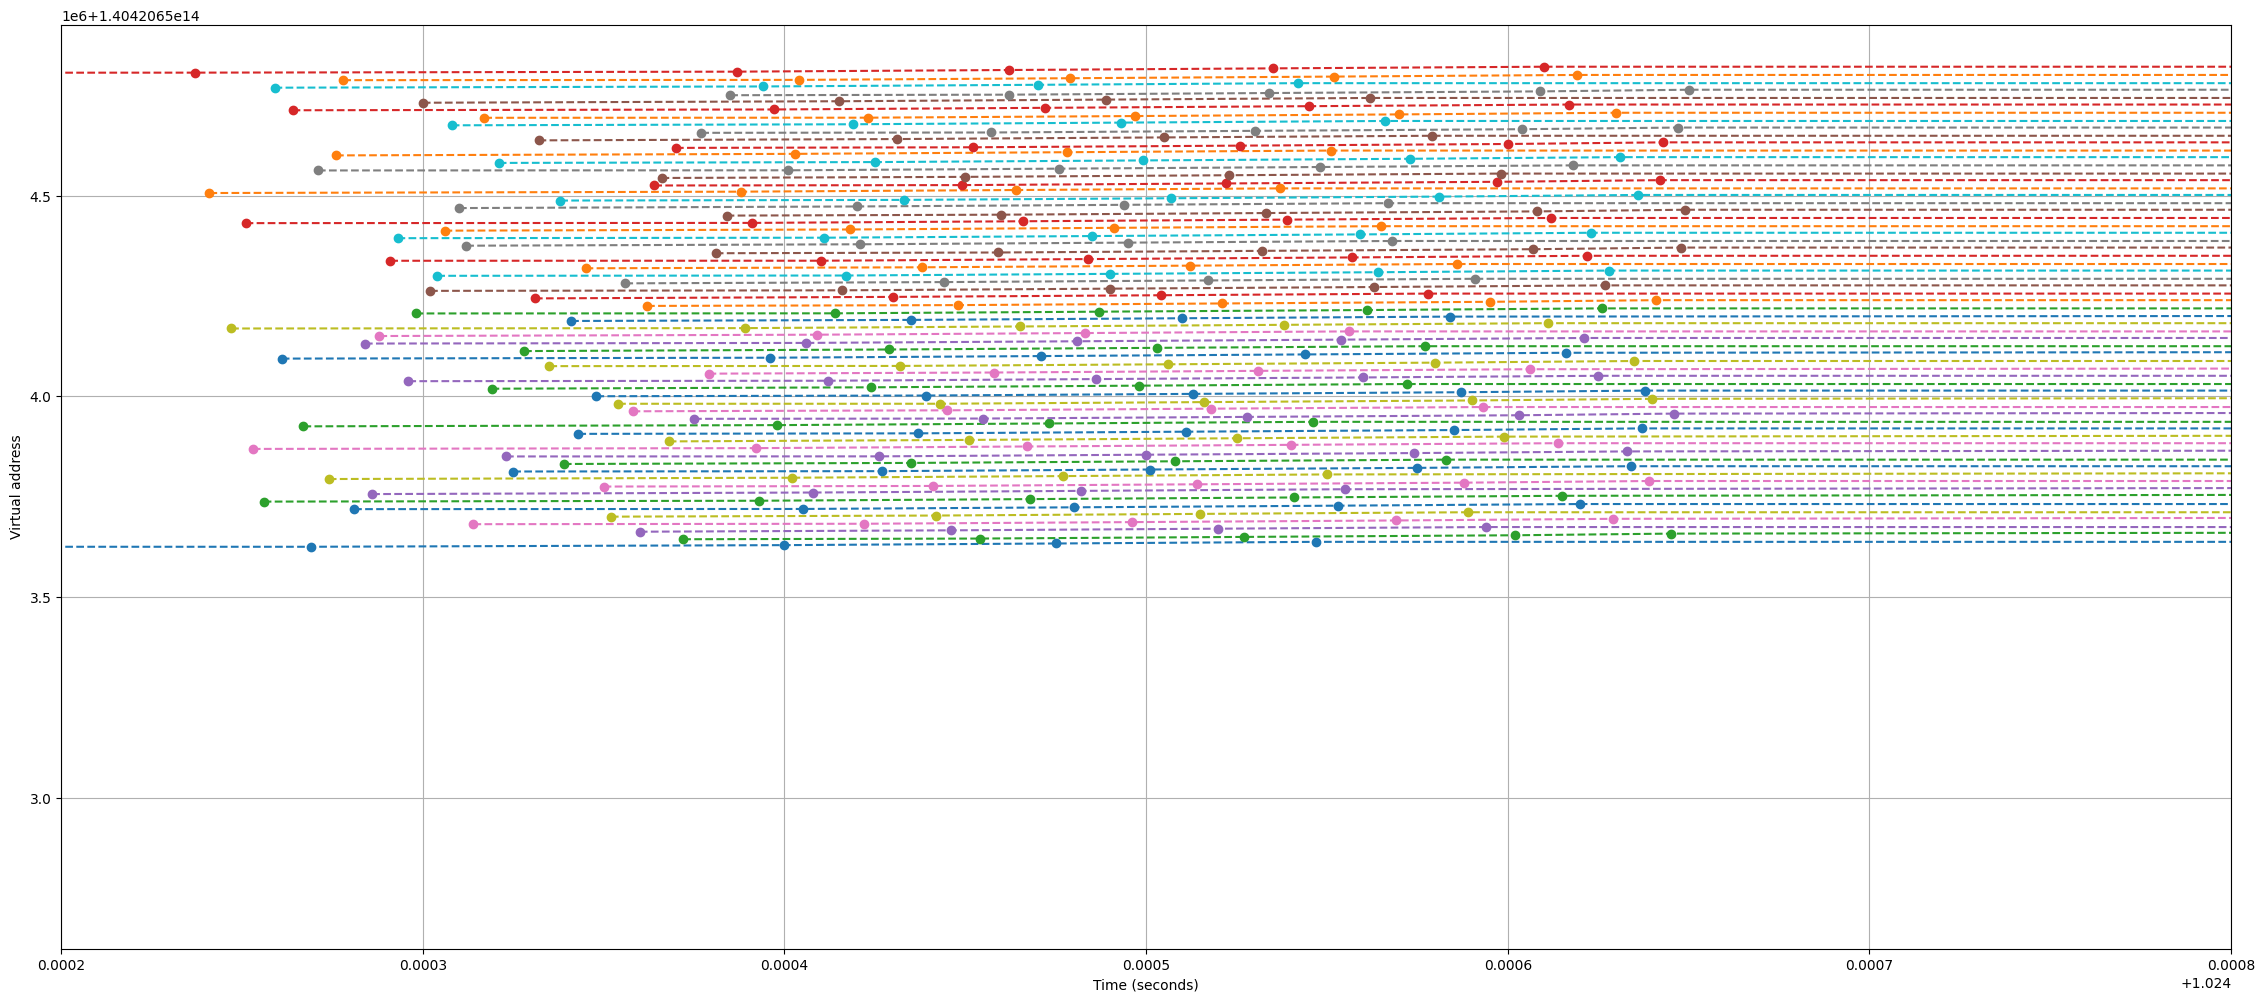

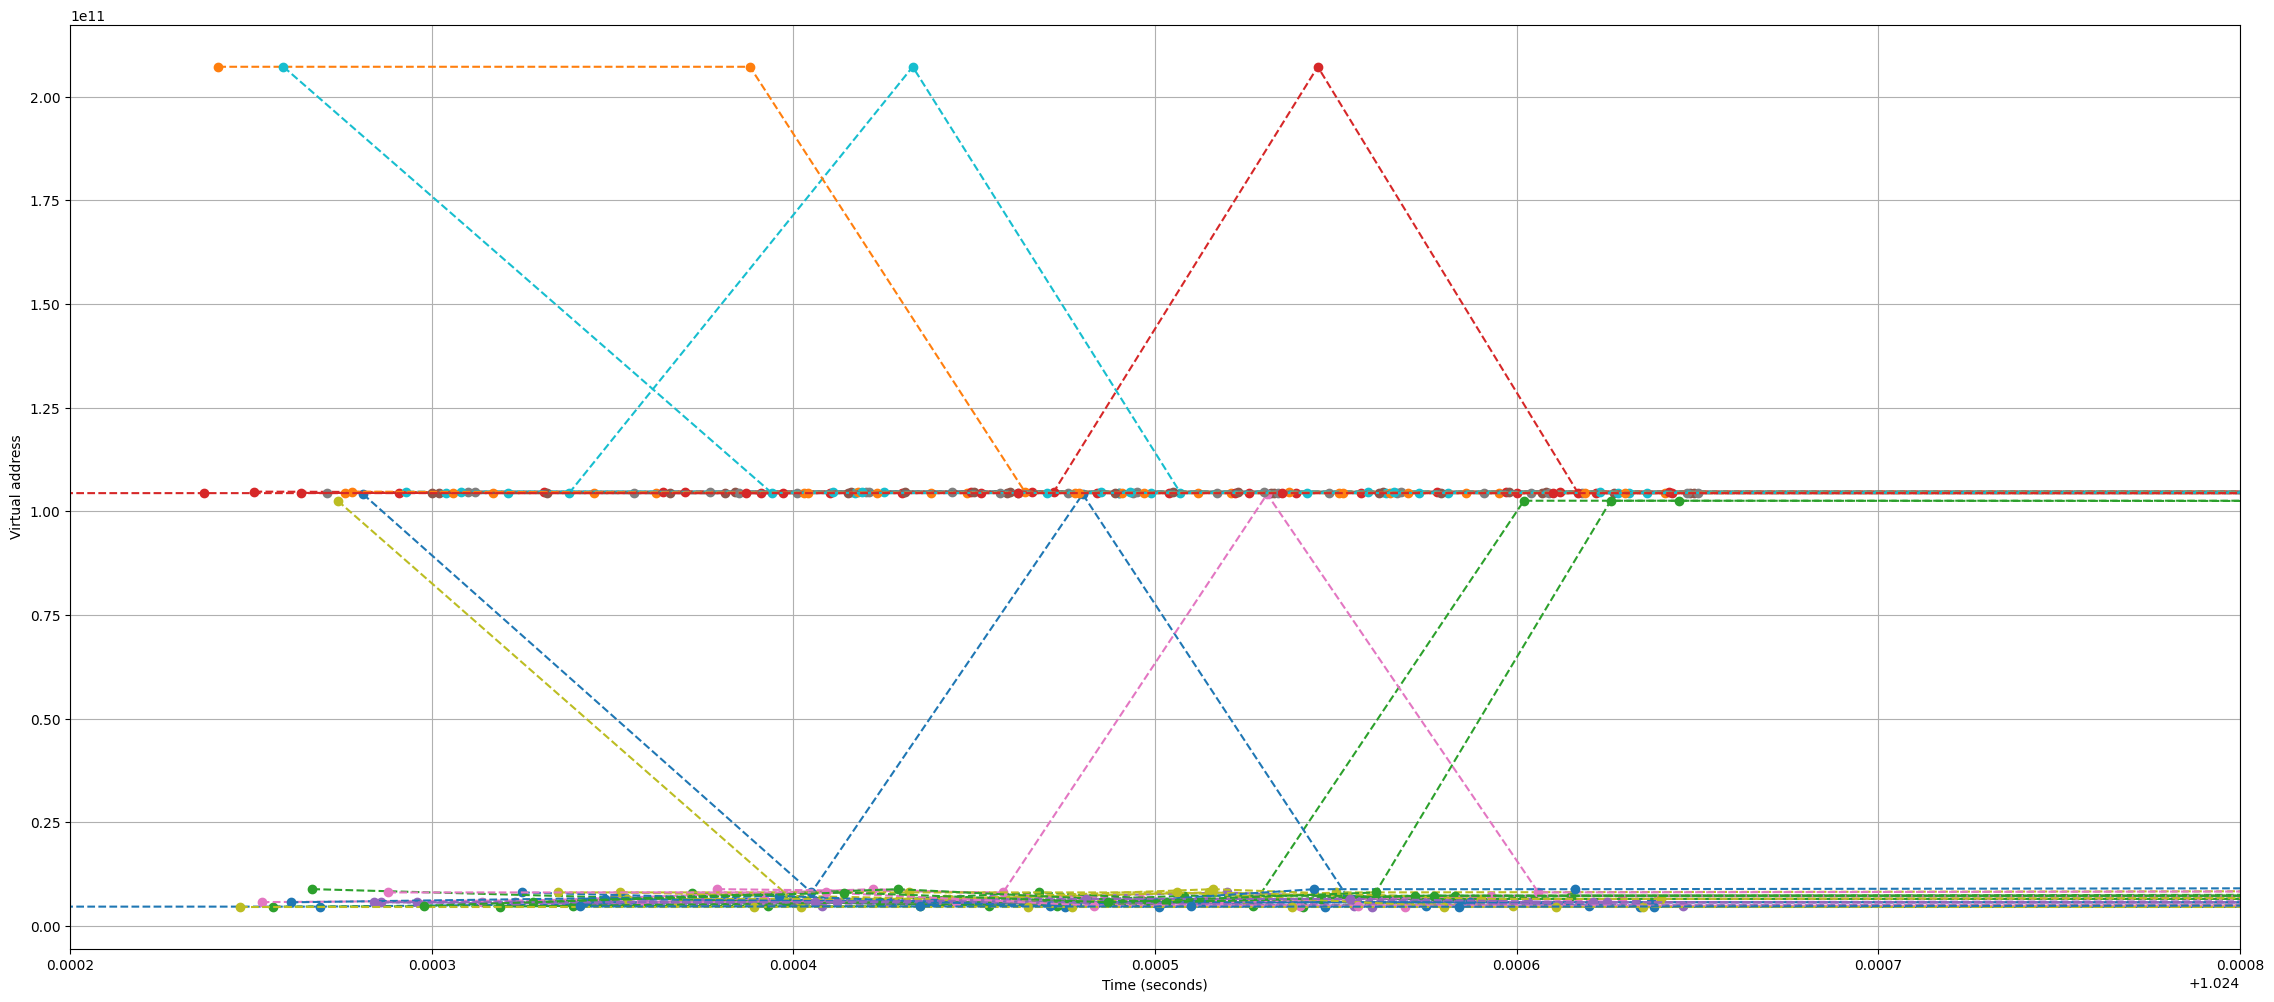

In [19]:
clusters_bounds, clusters_lengths = get_virtual_addrs_clusters(data)
print([(i, clusters_lengths[i]) for i in range(len(clusters_lengths))])

cluster_idx = 3
dataframes = filter_raw_data(data, min_virt_addr = clusters_bounds[cluster_idx][0], max_virt_addr = clusters_bounds[cluster_idx][1])


x_min = 1.0242
x_max = 1.0248
plot_filtered_data(dataframes, x_min = x_min, x_max = x_max)
plot_filtered_data(dataframes, column = "physical_addrs",  x_min = x_min, x_max = x_max)

## TODO

Merge all the memory accesses of CPUs on the same node, and plot that with local and remote node to try and see the access pattern at the scale of a node

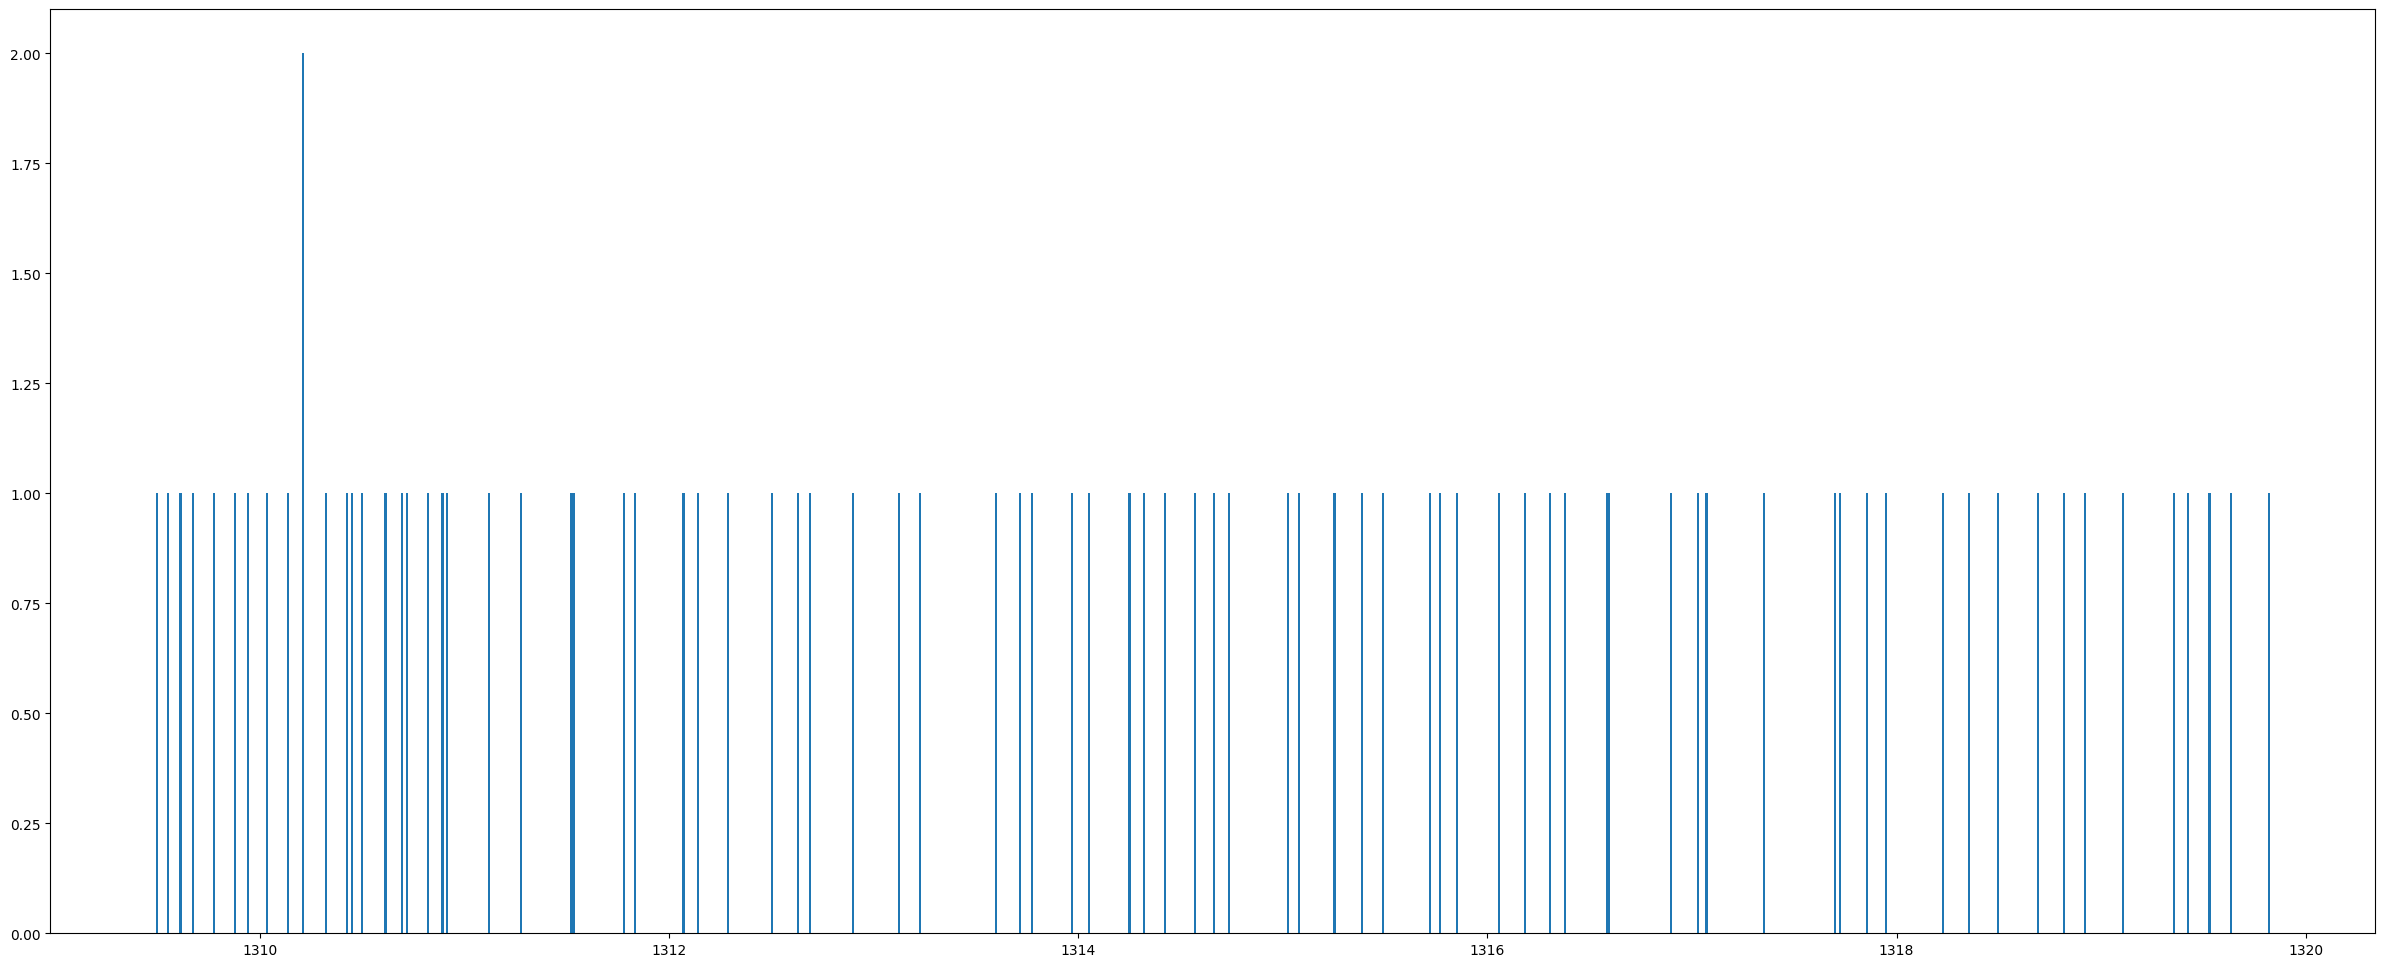

In [8]:
with open("graphs/timestamps_omp") as f :
    timestamps = []
    for line in f :
        timestamps.append(float(line))

plt.hist(timestamps, bins=1000)
fig = plt.gcf()
fig.set_size_inches(30, 12)
plt.show()

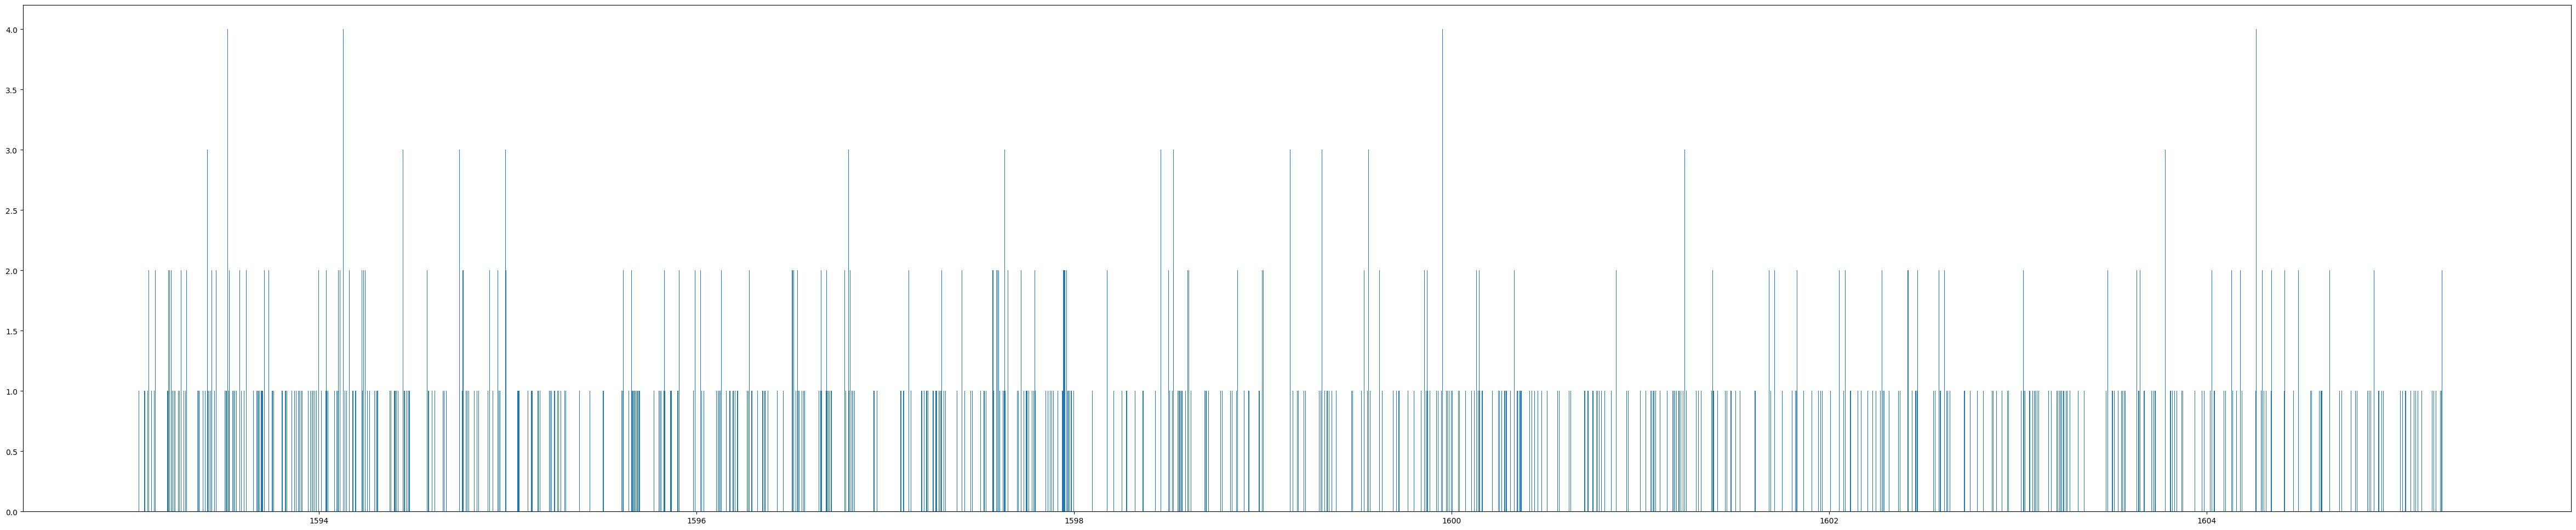

In [17]:
with open("graphs/timestamps_regular") as f :
    timestamps = []
    for line in f :
        timestamps.append(float(line))

plt.hist(timestamps, bins=20000)
fig = plt.gcf()
fig.set_size_inches(60, 12)
plt.show()

# TODO zoom on a small section and compare it with the trace of MEM accesses to see if it happens rather at the beginning of memory reads
# ALSO NEED TO DIFFERENCIATE BY CPU !

In [ ]:
def extract_memory_accesses(file_path: str) :
    temp_results_filename = ".results.json"
    result = subprocess.run(
        ["../cpp_parser/build/memory_accesses", file_path, temp_results_filename],
        stdout = subprocess.PIPE,
        universal_newlines = True
    )
    print(result)

def remove_outlier_addresses(addrs, timestamps, z_score_threshold = 2.0) :
    z_score = np.abs(stats.zscore(addrs))
    outlier_indices = np.where(z_score > z_score_threshold)[0]
    return np.delete(addrs, outlier_indices), np.delete(timestamps, outlier_indices)

def remove_before_t(np_addrs, np_timestamps, timestamp_cutoff) :
    filter_indices = np.where(np_timestamps >= timestamp_cutoff)[0]
    return np_addrs[filter_indices], np_timestamps[filter_indices]

def remove_after_t(np_addrs, np_timestamps, timestamp_cutoff) :
    filter_indices = np.where(np_timestamps <= timestamp_cutoff)[0]
    return np_addrs[filter_indices], np_timestamps[filter_indices]

def remove_under_a(np_addrs, np_timestamps, addr_cutoff) :
    filter_indices = np.where(np_addrs >= addr_cutoff)[0]
    return np_addrs[filter_indices], np_timestamps[filter_indices]

def remove_over_a(np_addrs, np_timestamps, addr_cutoff) :
    filter_indices = np.where(np_addrs < addr_cutoff)[0]
    return np_addrs[filter_indices], np_timestamps[filter_indices]

def hist_in_bounds(data, min_t = None, max_t = None, nbins = 1000) :
    all_timestamps = np.array([t for cpudata in data for t in cpudata["timestamps"]])
    if min_t is None :
        min_t = min(all_timestamps)
    if max_t is None :
        max_t = max(all_timestamps)
    times = all_timestamps[(all_timestamps >= min_t) & (all_timestamps <= max_t)]
    plt.hist(times, bins=nbins)
    plt.show()
    
def address_hist_in_bounds(data, min_a = None, max_a = None, nbins = 1000) :
    all_addresses = np.array([a for cpudata in data for a in cpudata["virtual_addrs"]])
    if min_a is None :
        min_a = min(all_addresses)
    if max_a is None :
        max_a = max(all_addresses)
    addrs = all_addresses[(all_addresses >= min_a) & (all_addresses <= max_a)]
    plt.hist(addrs, bins=nbins)
    plt.show()
    
    
# Just convert the CPU data to a dataframe ?
def filter_data(data: dict, min_t = None, max_t = None, min_virt_addr = None, max_virt_addr = None) -> List[pd.DataFrame] :
    dfs = []
    for cpu_data in data :
        cpu_df = pd.DataFrame({col: cpu_data[col] for col in cpu_data if col != "cpuid"})
        mask = np.array([True for _ in range(len(cpu_df))])
        if min_t :
            mask &= (cpu_df["timestamps"] >= min_t)
        if max_t is not None :
            mask &= (cpu_df["timestamps"] < max_t)
        if min_virt_addr is not None :
            mask &= (cpu_df["virtual_addrs"] >= min_virt_addr)
        if max_virt_addr is not None :
            mask &= (cpu_df["virtual_addrs"] < max_virt_addr)
        cpu_df = cpu_df[mask]
        
        dfs.append(cpu_df)
    return dfs
    

def plot_in_bounds(data, min_t = None, max_t = None, min_a = None, max_a = None, a_frame_func = None, width = None, height = None, plot_type = "plot", title = None) :
    if a_frame_func is None :
        a_frame_func = lambda x: x
    
    for cpudata in data :
        np_addrs = np.array(cpudata["virtual_addrs"])
        np_timestamps = np.array(cpudata["timestamps"])
        mask = (np_addrs >= 0)
        if min_t is not None :
            mask &= (np_timestamps >= min_t)
        if max_t is not None :
            mask &= (np_timestamps < max_t)
        if min_a is not None :
            mask &= (np_addrs >= min_a)
        if max_a is not None :
            mask &= (np_addrs < max_a)
            
        indices = np.where(mask)
        np_addrs = np_addrs[indices]
        np_timestamps = np_timestamps[indices]
        
        if plot_type == "scatter" :
            plt.scatter(np_timestamps, np_addrs, s=6, alpha=0.5)
        elif plot_type == "plot" :
            plt.plot(np_timestamps, np_addrs, marker='o', linestyle='--')
    fig = plt.gcf()
    if width is None :
        width = 28
    if height is None :
        height = 12
    fig.set_size_inches(width, height)
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    
    if title is not None :
        plt.title(title)
    
    plt.xlabel("Time (seconds)")
    plt.ylabel("Virtual address")
    plt.show()

In [ ]:
extract_memory_accesses(get_result_dir_path("_memory/cg.C.x__dahu-32__v6.8.0-rc6+__performance__2024-04-03/nb-enabled-test/cg.C.x__dahu-32__v6.8.0-rc6+__performance__2024-04-03__nb-enabled-test__4.log"))

In [ ]:
filename = get_absolute_result_dir_path("_memory/cg.C.x__dahu-32__v6.8.0-rc6+__performance__2024-04-03/nb-enabled-test/cg.C.x__dahu-32__v6.8.0-rc6+__performance__2024-04-03__nb-enabled-test__7.log")
temp_results_filename = ".results.json"
result = subprocess.run(
    ["../cpp_parser/build/memory_accesses", filename, temp_results_filename],
    stdout = subprocess.PIPE,
    universal_newlines = True
)
with open(temp_results_filename) as f:
    data = json.load(f)


In [ ]:
filter_data(data, min_t=2.0)

In [ ]:
virtual_addresses = np.concatenate([np.array(cpu['virtual_addrs']) for cpu in data])

In [ ]:
plotting = np.sort(virtual_addresses)[114:500]
plt.plot(range(len(plotting)), plotting)
fig = plt.gcf()
fig.set_size_inches(50, 20)
plt.show()


In [ ]:
def get_clusters(values: np.array, eps: int, min_size: int) -> Tuple[list, list] :
    sorted_values = np.sort(values)
    prev_val = np.concatenate(([sorted_values[0]],sorted_values[:-1])) # n - 1
    virtual_addresses_minus_diff = np.absolute(sorted_values - prev_val) # addr[i] - addr[i - 1]
    
    indices = np.where(virtual_addresses_minus_diff > eps)[0]
    
    clusters_bounds = [] # (min, max excluded)
    clusters_lengths = []
    if indices[0] >= min_size :
        clusters_bounds.append( (0, sorted_values[indices[0]]) )
        clusters_lengths.append(indices[0])
    for i in range(len(indices) - 1) :
        cluster_len = indices[i + 1] - indices[i]
        if cluster_len < min_size :
            continue
        clusters_bounds.append(( sorted_values[indices[i]], sorted_values[indices[i + 1]] ))
        clusters_lengths.append(cluster_len)
    
    return clusters_bounds, clusters_lengths
    

In [ ]:
clusters_bounds, clusters_lengths = get_clusters(np.concatenate([np.array(cpu['virtual_addrs']) for cpu in data]), 1e7, 10)
print(clusters_lengths)

cidx = 9
plot_in_bounds(data, min_a = clusters_bounds[cidx][0], max_a = clusters_bounds[cidx][1], min_t = 1.0, max_t = 1.2, width = 70, height = 45)
# plot_in_bounds(data, min_a=clusters[cidx][0], max_a=clusters[cidx][1], min_t=0.2, max_t=0.204)
# plot_in_bounds(data, min_a=clusters[cidx][0], max_a=clusters[cidx][1], min_t=0.218, max_t=0.22)

# plot_in_bounds(data, min_t=0.218, max_t=0.22)

In [ ]:

sorted_virtual_addresses = np.sort(np.concatenate([np.array(cpu['virtual_addrs']) for cpu in data]))
prev_val = np.concatenate(([sorted_virtual_addresses[0]],sorted_virtual_addresses[:-1])) # n - 1
virtual_addresses_minus_diff = np.absolute(sorted_virtual_addresses - prev_val) # addr[i] - addr[i - 1]

indices = np.where(virtual_addresses_minus_diff > 1e7)[0]

# cuts = virtual_addresses_minus_diff[virtual_addresses_minus_diff > 1000000]
print(len(indices))
print(indices)

In [ ]:
virtual_clusters = [(0, sorted_virtual_addresses[indices[0]])] # (min, max excluded)
for i in range(len(indices) - 1) :
    cluster_len = indices[i + 1] - indices[i]
    if cluster_len < 6 :
        continue
    print(f"Cluster {len(virtual_clusters)} len : {indices[i + 1] - indices[i]}")
    virtual_clusters.append(( sorted_virtual_addresses[indices[i]], sorted_virtual_addresses[indices[i + 1]] ))

virtual_clusters
cidx = 2

min_addr = virtual_clusters[cidx][0]
max_addr = virtual_clusters[cidx][1]
print(f"min_addr : {min_addr}\nmax_addr : {max_addr}")

# plot_in_bounds(data, min_a=virtual_clusters[cidx][0], max_a=virtual_clusters[cidx][1])

sorted_virtual_addresses[(sorted_virtual_addresses >= min_addr) & (sorted_virtual_addresses <= max_addr)]

In [ ]:
virtual_addresses = np.concatenate([np.array(cpu['virtual_addrs']) for cpu in data])
reshaped_virtual_addresses = (virtual_addresses / 100000).reshape(-1, 1)
# virtual_addresses

# X = np.array([[1, 2], [2, 2], [2, 3], [8, 7], [8, 8], [25, 80]])

clustering = DBSCAN(eps=0.5).fit(reshaped_virtual_addresses)
clustering.labels_

groups = defaultdict(list)
for label, addr in zip(clustering.labels_, virtual_addresses) :
    groups[label].append(addr)

# plt.plot(range(5), virtual_addresses[-5:])
# plt.plot()

plt.plot(range(len(virtual_addresses)), sorted(virtual_addresses))
plt.show()

plt.plot(range(len(clustering.labels_)), clustering.labels_)
fig = plt.gcf()
fig.set_size_inches(50, 20)
plt.show()

In [ ]:
plt.plot(range(len(clustering.labels_)), clustering.labels_)
fig = plt.gcf()
fig.set_size_inches(50, 20)
plt.show()

In [ ]:
for group, values in groups.items() :
    print("Group", group, "max diff :", max(values) - min(values))

In [ ]:
virtual_addresses = np.concatenate([np.array(cpu['virtual_addrs']) for cpu in data])
plt.hist(virtual_addresses, bins=50)
plt.show()

In [ ]:
# TODO In the cpp code, have a snippet that extracts the log files if not done already
filename = get_absolute_result_dir_path("_memory/cg.C.x__dahu-32__v6.8.0-rc6+__performance__2024-04-03/nb-enabled-test/cg.C.x__dahu-32__v6.8.0-rc6+__performance__2024-04-03__nb-enabled-test__7.log")
print(filename)

# TODO Defer the deletion of that file
temp_results_filename = ".results.json"
result = subprocess.run(
    ["../cpp_parser/build/memory_accesses", filename, temp_results_filename],
    stdout = subprocess.PIPE,
    universal_newlines = True
)
with open(temp_results_filename) as f:
    data = json.load(f)

# hist_in_bounds(data, 1.0, 1.2)
# hist_in_bounds(data, 1.0, 1.2)

# plot_in_bounds(data, 2.017, 2.018, 1.35 * 1e14, 1.4 * 1e14)
# plot_in_bounds(data, 1.016, 1.023, 1.3 * 1e14)
# plot_in_bounds(data, 1.016, 1.023, 7, 8, lambda x : x * 1e7 + 1.398e14)

In [ ]:
# address_hist_in_bounds(data, 1.34 * 1e14)
# address_hist_in_bounds(data, 1.34 * 1e14, 1.398 * 1e14)

frame = lambda x: x * 1e9 + 1.3971e14
address_hist_in_bounds(data, frame(5.4), frame(5.6))

frameleft = lambda x: x * 1e7 + 1.397155e14
address_hist_in_bounds(data, frameleft(1.2), frameleft(1.6))

frameright = lambda x: x * 1e6 + 1.3971551e14
address_hist_in_bounds(data, frameleft(1.75), frameleft(2.0))



In [ ]:
# plot_in_bounds(data, None, None, 1.2, 1.6, a_frame_func=frameleft, width = 50, height = 30)

plot_in_bounds(data, None, None, 1.75, 2.0, a_frame_func=frameleft, width = 50, height = 30)


In [ ]:
# address_hist_in_bounds(data, 1.34 * 1e14, 1.398 * 1e14)

frame = lambda x: x * 1e6 + 1.3971488e14
address_hist_in_bounds(data, frame(4.0), frame(7))

# frame = lambda x: x * 1e9 + 1.3971e14
# address_hist_in_bounds(data, frame(5.45), frame(5.6))



In [ ]:
# frame = lambda x: x * 1e6 + 1.3971488e14
# address_hist_in_bounds(data, frame(4.0), frame(7))
plot_in_bounds(data, None, None, 4.0, 7.0, a_frame_func=lambda x: x * 1e6 + 1.3971488e14)


In [ ]:
## From the program itself

data = [{"cpuid": i, "timestamps": [], "virtual_addrs": []} for i in range(64)]

with open("output.txt") as f :
    for line in f :
        match = re.match(r'\s*\w+\[addr:\s+(\d+)[^\]]+thread:\s+(\d+)[^\]]+time:\s+(\d+\.\d+)', line)
        if match :
            cpudata = data[int(match.group(2))]
            cpudata["timestamps"].append(float(match.group(3)))
            cpudata["virtual_addrs"].append(int(match.group(1)))
            
        # data[match.group(1)]
        
# cpudata = data[0]
# for cpudata in data[:11] :
#     np_addrs = np.array(cpudata["virtual_addrs"])
#     np_timestamps = np.array(cpudata["timestamps"])
#     np_addrs, np_timestamps = remove_before_t(np_addrs, np_timestamps, 1.267)
#     np_addrs, np_timestamps = remove_after_t(np_addrs, np_timestamps, 1.4)
#     plt.plot(np_timestamps, np_addrs, marker='o', linestyle='--')
# fig = plt.gcf()
# fig.set_size_inches(30, 12)
# plt.grid(axis="y", which="both")
# plt.grid(axis="x", which="major")
# plt.show()

plot_in_bounds(data, 1.2, 1.4, a_frame_func = lambda x: x * 1e8 + 1.39914e14, min_a=6.5, width=40, height=20, title="Per thread subset of virtual memory accesses from cg.C, printed during program execution")


What we can see above is a read phase (only higher addresses), followed by a write phase

In [ ]:
plot_in_bounds(data, 0, 5, a_frame_func = lambda x: x * 1e8 + 1.39914e14, min_a=6.5, width=80, height=40, title="Per thread subset of virtual memory accesses from cg.C, printed during program execution")

In [ ]:
plot_in_bounds(data, 0, 2, a_frame_func = lambda x: x * 1e8 + 1.39914e14, width=50, height=20, title="Per thread subset of virtual memory accesses from cg.C, printed during program execution")

In [ ]:
data = [{"cpuid": i, "timestamps": [], "virtual_addrs": []} for i in range(64)]

with open("output2.txt") as f :
    for line in f :
        match = re.match(r'\s*\w+\[addr:\s+(\d+)[^\]]+thread:\s+(\d+)[^\]]+time:\s+(\d+\.\d+)', line)
        if match :
            cpudata = data[int(match.group(2))]
            cpudata["timestamps"].append(float(match.group(3)))
            cpudata["virtual_addrs"].append(int(match.group(1)))

In [ ]:
plot_in_bounds(data, 0, 1.5, a_frame_func = lambda x: x * 1e9 + 1.4013e14, min_a=4.0, max_a=4.2, width=50, height=20, title="Per thread subset of virtual memory accesses from cg.C, printed during program execution")

In [ ]:
plot_in_bounds(data, 0, 2, a_frame_func = lambda x: x * 1e9 + 1.4013e14, max_a=4.0, width=50, height=20, title="Per thread subset of virtual memory accesses from cg.C, printed during program execution")